In [1]:
import pandas as pd
import os
from multiprocess import Pool
import numpy as np
import math
from sklearn.base import BaseEstimator, TransformerMixin

In [2]:
# !pip install multiprocess
# !pip install tensorflow-gpu
# !pip install keras

In [3]:
def create_combined_dataset(path_to_raw_data_folder):
    data = [pd.read_csv(f'{path_to_raw_data_folder}/{i}', low_memory = False, skiprows=1) for i in os.listdir(path_to_raw_data_folder) if i.endswith('.zip')]
    return pd.concat(data)
    
def read_one(path):
    return pd.read_csv(path, skiprows=1,  engine='python')

def create_combined_dataset_parallel(path_to_raw_data_folder):
    
    files = [f'{path_to_raw_data_folder}/{i}'for i in os.listdir(path_to_raw_data_folder)]
    print(files)
    p = Pool(10)
    data = p.map(read_one, files)
    p.close()
    return data

def build_dataset():
    features = ['loan_amnt'
                , 'term'
                , 'int_rate'
                , 'installment'
                , 'grade'
                , 'sub_grade'
                , 'emp_title'
                , 'emp_length'
                , 'home_ownership'
                , 'annual_inc'
                , 'verification_status'
                , 'purpose'
                , 'title'
                , 'addr_state'
                , 'dti'
                , 'delinq_2yrs'
                , 'earliest_cr_line'
                , 'fico_range_low'
                , 'fico_range_high'
                , 'inq_last_6mths'
                , 'mths_since_last_delinq'
                , 'mths_since_last_record'
                , 'open_acc'
                , 'pub_rec'
                , 'revol_bal'
                , 'revol_util'
                , 'total_acc'
                , 'initial_list_status'
                , 'loan_status'
               ]
    data = create_combined_dataset_parallel('data')
    df = pd.concat(data)
    status_list = ['Fully Paid', 'Charged Off', 'Late (31-120 days)', 'Default']
    df = df[df['loan_status'].isin(status_list)]
    df['loan_status'] = df['loan_status'].apply(make_target)
    return df[features]

def make_target(val):
    if val in ['Charged Off', 'Late (31-120 days)', 'Default']:
        return 1
    else:
        return 0

In [4]:
df = build_dataset()

['data/LoanStats3a_securev1.csv.zip', 'data/LoanStats3b_securev1.csv.zip', 'data/LoanStats3c_securev1.csv.zip', 'data/LoanStats3d_securev1.csv.zip', 'data/LoanStats_securev1_2016Q1.csv.zip', 'data/LoanStats_securev1_2016Q2.csv.zip', 'data/LoanStats_securev1_2016Q3.csv.zip', 'data/LoanStats_securev1_2016Q4.csv.zip', 'data/LoanStats_securev1_2017Q1.csv.zip', 'data/LoanStats_securev1_2017Q2.csv.zip', 'data/LoanStats_securev1_2017Q3.csv.zip', 'data/LoanStats_securev1_2017Q4.csv.zip', 'data/LoanStats_securev1_2018Q1.csv.zip', 'data/LoanStats_securev1_2018Q2.csv.zip', 'data/LoanStats_securev1_2018Q3.csv.zip', 'data/LoanStats_securev1_2018Q4.csv.zip', 'data/LoanStats_securev1_2019Q1.csv.zip', 'data/LoanStats_securev1_2019Q2.csv.zip', 'data/LoanStats_securev1_2019Q3.csv.zip', 'data/LoanStats_securev1_2019Q4.csv.zip', 'data/LoanStats_securev1_2020Q1.csv.zip', 'data/LoanStats_securev1_2020Q2.csv.zip']


In [5]:
df.head()

,loan_amnt,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,...,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,loan_status
0,5000.0,36 months,10.65%,162.87,B,B2,NaN,10+ years,RENT,24000.0,...,1.0,NaN,NaN,3.0,0.0,13648.0,83.7%,9.0,f,0
1,2500.0,60 months,15.27%,59.83,C,C4,Ryder,< 1 year,RENT,30000.0,...,5.0,NaN,NaN,3.0,0.0,1687.0,9.4%,4.0,f,1
2,2400.0,36 months,15.96%,84.33,C,C5,NaN,10+ years,RENT,12252.0,...,2.0,NaN,NaN,2.0,0.0,2956.0,98.5%,10.0,f,0
3,10000.0,36 months,13.49%,339.31,C,C1,AIR RESOURCES BOARD,10+ years,RENT,49200.0,...,1.0,35.0,NaN,10.0,0.0,5598.0,21%,37.0,f,0
4,3000.0,60 months,12.69%,67.79,B,B5,University Medical Group,1 year,RENT,80000.0,...,0.0,38.0,NaN,15.0,0.0,27783.0,53.9%,38.0,f,0


In [6]:
df.shape

(1979925, 29)

In [7]:
# Custom Transforms
class fix_percent(BaseEstimator, TransformerMixin):
    
    def __init__(self):
        pass 
    
    def fit(self, X, y = None):
        return self
    
    def transform(self, X, y=None):
        _X = X.copy()
        
        for i in X.columns:
            _X[i] = _X[i].str.replace('%', '').astype(float)/100
        return _X

In [8]:
from sklearn.impute import SimpleImputer, MissingIndicator
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, KBinsDiscretizer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# Features that we want to leave untransformed:
# Only numeric features need apply:
standardize_and_impute_only = [
'loan_amnt'
, 'annual_inc'
, 'delinq_2yrs'
, 'inq_last_6mths'
, 'open_acc'
]


# maybe we will trying some polynomial transofmrations
polynomial_features = [
'installment'
, 'dti'
]

# how about some discretizations?
discretization = [
'fico_range_low'
, 'fico_range_high'
, 'mths_since_last_delinq'
, 'mths_since_last_record'
, 'pub_rec'
, 'revol_bal'
, 'total_acc'
]

# let's construct all of our transformers
standard_scaler = StandardScaler()
missing_indicator = MissingIndicator(features="all")
simple_imputer = SimpleImputer(strategy='median')
polynomial_featurizer = PolynomialFeatures(2)
discretizer = KBinsDiscretizer(n_bins=8, encode='ordinal', strategy='uniform')
fix_percent_transformer = fix_percent()

# and make the pipelines
standardize_and_impute_pipeline_steps = [('standardization', standard_scaler), ('imputer', simple_imputer)]
standardize_and_impute_pipeline = Pipeline(standardize_and_impute_pipeline_steps)

polynomial_pipeline_steps = standardize_and_impute_pipeline_steps + [('polynomial', polynomial_featurizer)]
polynomial_pipeline = Pipeline(polynomial_pipeline_steps)

discretize_steps = [('imputer', simple_imputer), ('discretize', discretizer)]
discretize_pipeline = Pipeline(discretize_steps)

interest_rate_steps = [('fix_int_rate', fix_percent_transformer)] + standardize_and_impute_pipeline_steps
interest_rate_pipeline = Pipeline(interest_rate_steps)

missing_flag_steps = [('missing_flag', missing_indicator)]
missing_flag_pipeline = Pipeline(missing_flag_steps)

#now we can use a ColumnTransformer to do everything
transform_pipeline = ColumnTransformer([
    ('standardize_and_impute_pipeline', standardize_and_impute_pipeline, standardize_and_impute_only)
     , ('polynomial_pipeline', polynomial_pipeline, polynomial_features)
     , ('discretize_pipeline', discretize_pipeline, discretization)
     , ('interest_rate_pipeline', interest_rate_pipeline, ['int_rate'])
     , ('missing_flag_pipeline', missing_flag_pipeline, standardize_and_impute_only + polynomial_features + discretization)
])


# Building a Keras model(Deep learning)

In [44]:
from sklearn.model_selection import GridSearchCV, KFold
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from keras.optimizers import Adam
from keras.layers import Dropout
from sklearn.model_selection import train_test_split
from sklearn.utils import resample

### Load & Balance the dataset(using upsampling method)

In [97]:
#Check for the class distribution balance
data = df.sample(n=10000, random_state=6)
df.loan_status.value_counts()

0    1589345
1     390580
Name: loan_status, dtype: int64

In [99]:
# Separate majority and minority classes
df_majority = data[data.loan_status==0]
df_minority = data[data.loan_status==1]
 
# Upsample minority class
df_minority_upsampled = resample(df_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples=8000,    # to match majority class
                                 random_state=123) # reproducible results
 
# Combine majority class with upsampled minority class
df_upsampled = pd.concat([df_majority, df_minority_upsampled])
df_upsampled.loan_status.value_counts()

0    8050
1    8000
Name: loan_status, dtype: int64

## Test & Train Split

In [100]:
#Test Train Split

train, test = train_test_split(df_upsampled, test_size=0.2, shuffle=True, random_state=6)

X = train.drop(['loan_status'], axis = 1)
y = train[['loan_status']]

X_test = test.drop(['loan_status'], axis = 1)
y_test = test[['loan_status']]

# Define a random seed
seed = 6
np.random.seed(seed)

## 1 Grid Search(FineTune deep learning classification model)

### 1.1 Find Optimal batch size and number of epochs

In [54]:
def create_model():
    # create deep neural networks
    model = Sequential()
    model.add(Dense(8, input_dim = 33, kernel_initializer='normal', activation='relu'))
    model.add(Dense(4, input_dim = 8, kernel_initializer='normal', activation='relu'))
    model.add(Dense(1, activation='sigmoid'))   
    # compile the model
    adam = Adam(lr = 0.01)
    model.compile(loss = 'binary_crossentropy', optimizer = adam, metrics = ['accuracy'])
    return model

# create the model
model = KerasClassifier(build_fn = create_model, verbose = 1)

# define the grid search parameters
batch_size = [2, 4, 8,16, 24, 32,64]
epochs = [50, 100,150,200,300]
param_grid = dict(batch_size=batch_size, epochs=epochs)

# Build and fit the GridSearchCV
cross_validation = KFold(n_splits=3, shuffle=True, random_state=seed)

gridsearch_batch_size = GridSearchCV(estimator = model, param_grid = param_grid, cv = cross_validation, verbose = 10, n_jobs=15)

# Trigger the pipeline
pipeline_gridsearch = Pipeline([('transform', transform_pipeline),
                                ('gridsearch', gridsearch_batch_size)])

pipeline_gridsearch.fit(X, y)

# THis will be needed to print gridsearch best params
def print_optimal_params(named_steps):
    grid_results=pipeline_gridsearch.named_steps[named_steps]
    print("Best: {0}, using {1}".format(grid_results.best_score_, grid_results.best_params_))
    means = grid_results.cv_results_['mean_test_score']
    stds = grid_results.cv_results_['std_test_score']
    params = grid_results.cv_results_['params']
    for mean, stdev, param in zip(means, stds, params):
        print('{0} ({1}) with: {2}'.format(mean, stdev, param))
        
print_optimal_params('gridsearch')

Fitting 3 folds for each of 35 candidates, totalling 105 fits


[Parallel(n_jobs=15)]: Using backend LokyBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done   2 tasks      | elapsed:  5.4min
[Parallel(n_jobs=15)]: Done  11 tasks      | elapsed: 13.5min
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed: 20.6min
[Parallel(n_jobs=15)]: Done  31 tasks      | elapsed: 25.9min
[Parallel(n_jobs=15)]: Done  42 tasks      | elapsed: 29.5min
[Parallel(n_jobs=15)]: Done  55 tasks      | elapsed: 33.0min
[Parallel(n_jobs=15)]: Done  68 tasks      | elapsed: 34.3min
[Parallel(n_jobs=15)]: Done  87 out of 105 | elapsed: 35.9min remaining:  7.4min
[Parallel(n_jobs=15)]: Done  98 out of 105 | elapsed: 36.7min remaining:  2.6min
[Parallel(n_jobs=15)]: Done 105 out of 105 | elapsed: 37.2min finished


Epoch 1/150
12840/12840 [==============================] - 0s 25us/step - loss: 0.6527 - accuracy: 0.6222
Epoch 2/150
12840/12840 [==============================] - 0s 16us/step - loss: 0.6408 - accuracy: 0.6379
Epoch 3/150
12840/12840 [==============================] - 0s 14us/step - loss: 0.6396 - accuracy: 0.6380
Epoch 4/150
12840/12840 [==============================] - 0s 14us/step - loss: 0.6386 - accuracy: 0.6389
Epoch 5/150
12840/12840 [==============================] - 0s 14us/step - loss: 0.6375 - accuracy: 0.6411
Epoch 6/150
12840/12840 [==============================] - 0s 14us/step - loss: 0.6367 - accuracy: 0.6407
Epoch 7/150
12840/12840 [==============================] - 0s 14us/step - loss: 0.6340 - accuracy: 0.6430
Epoch 8/150
12840/12840 [==============================] - 0s 13us/step - loss: 0.6337 - accuracy: 0.6457
Epoch 9/150
12840/12840 [==============================] - 0s 14us/step - loss: 0.6308 - accuracy: 0.6491
Epoch 10/150
12840/12840 [====================

### 1.2 Find optimal  learning rate and dropout rate

In [60]:
def lean_dropout_optimizer_model(learn_rate, dropout_rate):
     # create deep neural networks
    model = Sequential()
    model.add(Dense(8, input_dim = 33, kernel_initializer='normal', activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(4, input_dim = 8, kernel_initializer='normal', activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation='sigmoid'))
    
    # compile the model
    adam = Adam(lr = learn_rate)
    model.compile(loss = 'binary_crossentropy', optimizer = adam, metrics = ['accuracy'])
    return model

# create the model
model = KerasClassifier(build_fn = lean_dropout_optimizer_model, epochs = 150, batch_size = 64, verbose = 0)

# define the grid search parameters
learn_rate = [0.001, 0.01, 0.1]
dropout_rate = [0.0, 0.1, 0.2]
param_grid = dict(learn_rate=learn_rate, dropout_rate=dropout_rate)

# build and fit the GridSearchCV
learn_dropout_gridsearch = GridSearchCV(estimator = model, param_grid = param_grid, cv = cross_validation, verbose = 10, n_jobs=20)

# Trigger the pipeline
pipeline_gridsearch = Pipeline([('transform', transform_pipeline),
                                ('gridsearch', learn_dropout_gridsearch)])

pipeline_gridsearch.fit(X, y)

#print best params
print_optimal_params('gridsearch')

Fitting 4 folds for each of 9 candidates, totalling 36 fits


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   5 out of  36 | elapsed:   53.8s remaining:  5.6min
[Parallel(n_jobs=20)]: Done   9 out of  36 | elapsed:   54.1s remaining:  2.7min
[Parallel(n_jobs=20)]: Done  13 out of  36 | elapsed:  1.0min remaining:  1.8min
[Parallel(n_jobs=20)]: Done  17 out of  36 | elapsed:  1.0min remaining:  1.2min
[Parallel(n_jobs=20)]: Done  21 out of  36 | elapsed:  1.8min remaining:  1.3min
[Parallel(n_jobs=20)]: Done  25 out of  36 | elapsed:  1.8min remaining:   46.9s
[Parallel(n_jobs=20)]: Done  29 out of  36 | elapsed:  1.8min remaining:   25.9s
[Parallel(n_jobs=20)]: Done  33 out of  36 | elapsed:  1.9min remaining:   10.1s
[Parallel(n_jobs=20)]: Done  36 out of  36 | elapsed:  1.9min finished


Best: 0.648753896355629, using {'dropout_rate': 0.1, 'learn_rate': 0.01}
0.6469626128673553 (0.008869956768152198) with: {'dropout_rate': 0.0, 'learn_rate': 0.001}
0.6486760228872299 (0.011241690867811256) with: {'dropout_rate': 0.0, 'learn_rate': 0.01}
0.4947819262742996 (0.0058380096095761586) with: {'dropout_rate': 0.0, 'learn_rate': 0.1}
0.6468068510293961 (0.013491970602755496) with: {'dropout_rate': 0.1, 'learn_rate': 0.001}
0.648753896355629 (0.011659367941394893) with: {'dropout_rate': 0.1, 'learn_rate': 0.01}
0.504283495247364 (0.006554565736993826) with: {'dropout_rate': 0.1, 'learn_rate': 0.1}
0.6480529606342316 (0.0031337183298665553) with: {'dropout_rate': 0.2, 'learn_rate': 0.001}
0.6485981494188309 (0.009487517435158892) with: {'dropout_rate': 0.2, 'learn_rate': 0.01}
0.4966510906815529 (0.007077815334662375) with: {'dropout_rate': 0.2, 'learn_rate': 0.1}


### 1.3 Find Optimal kernel initialization and activation functions

In [62]:
def kernel_activation_optimizer_model(activation, init):
     # create deep neural networks
    model = Sequential()
    model.add(Dense(8, input_dim = 33, kernel_initializer= init, activation= activation))
    model.add(Dropout(0.1))
    model.add(Dense(4, input_dim = 8, kernel_initializer= init, activation= activation))
    model.add(Dropout(0.1))
    model.add(Dense(1, activation='sigmoid'))
    # compile the model
    adam = Adam(lr = 0.01)
    model.compile(loss = 'binary_crossentropy', optimizer = adam, metrics = ['accuracy'])
    return model

# create the model
model = KerasClassifier(build_fn = kernel_activation_optimizer_model, epochs = 150, batch_size = 64, verbose = 0)

# define the grid search parameters
activation = ['softmax', 'relu', 'tanh', 'linear']
init = ['uniform', 'normal', 'zero']
param_grid = dict(activation = activation, init = init)

# build and fit the GridSearchCV
kernel_activation_gridsearch = GridSearchCV(estimator = model, param_grid = param_grid, cv = cross_validation, verbose = 10, n_jobs=20)

# Trigger the pipeline
pipeline_gridsearch = Pipeline([('transform', transform_pipeline),
                                ('gridsearch', kernel_activation_gridsearch)])
pipeline_gridsearch.fit(X, y)

#print best params
print_optimal_params('gridsearch')

Fitting 4 folds for each of 12 candidates, totalling 48 fits


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   1 tasks      | elapsed:  1.0min
[Parallel(n_jobs=20)]: Done  14 out of  48 | elapsed:  1.1min remaining:  2.6min
[Parallel(n_jobs=20)]: Done  19 out of  48 | elapsed:  1.1min remaining:  1.7min
[Parallel(n_jobs=20)]: Done  24 out of  48 | elapsed:  2.0min remaining:  2.0min
[Parallel(n_jobs=20)]: Done  29 out of  48 | elapsed:  2.0min remaining:  1.3min
[Parallel(n_jobs=20)]: Done  34 out of  48 | elapsed:  2.1min remaining:   50.9s
[Parallel(n_jobs=20)]: Done  39 out of  48 | elapsed:  2.1min remaining:   28.7s
[Parallel(n_jobs=20)]: Done  44 out of  48 | elapsed:  2.7min remaining:   14.5s
[Parallel(n_jobs=20)]: Done  48 out of  48 | elapsed:  2.7min finished


Best: 0.6595015525817871, using {'activation': 'tanh', 'init': 'uniform'}
0.6507009416818619 (0.006812296308101788) with: {'activation': 'softmax', 'init': 'uniform'}
0.6516355127096176 (0.014564288202384904) with: {'activation': 'softmax', 'init': 'normal'}
0.6476635485887527 (0.00846011009205243) with: {'activation': 'softmax', 'init': 'zero'}
0.6481308341026306 (0.003165496393552806) with: {'activation': 'relu', 'init': 'uniform'}
0.6514018625020981 (0.012459116108857348) with: {'activation': 'relu', 'init': 'normal'}
0.49571650475263596 (0.0065545625499760654) with: {'activation': 'relu', 'init': 'zero'}
0.6595015525817871 (0.01052524910970929) with: {'activation': 'tanh', 'init': 'uniform'}
0.655373826622963 (0.008967893104759447) with: {'activation': 'tanh', 'init': 'normal'}
0.4975856691598892 (0.007448600021255313) with: {'activation': 'tanh', 'init': 'zero'}
0.639719620347023 (0.009896791729817122) with: {'activation': 'linear', 'init': 'uniform'}
0.6342678964138031 (0.0096346

### 1.4 Find the optimal number of neurons in each hidden layer


In [63]:
def neuron_optimizer_model(neuron1, neuron2):
     # create deep neural networks
    model = Sequential()
    model.add(Dense(neuron1, input_dim = 33, kernel_initializer= 'uniform', activation= 'tanh'))
    model.add(Dropout(0.1))
    model.add(Dense(neuron2, input_dim = neuron1, kernel_initializer= 'uniform', activation= 'tanh'))
    model.add(Dropout(0.1))
    model.add(Dense(1, activation='sigmoid'))
    # compile the model
    adam = Adam(lr = 0.01)
    model.compile(loss = 'binary_crossentropy', optimizer = adam, metrics = ['accuracy'])
    return model

# Create a Classifier model
model = KerasClassifier(build_fn = neuron_optimizer_model, epochs = 150, batch_size = 64, verbose = 0)

# Make a dictionary of the grid search parameters
neuron1 = [4,8,16,32,64,72]
neuron2 = [2,4,8,16,32,64]
param_grid = dict(neuron1 = neuron1, neuron2 = neuron2)

# Build and fit the GridSearchCV
cross_validation = KFold(n_splits=4, shuffle=True, random_state=seed)
neuron_optimizer_gridsearch = GridSearchCV(estimator = model, param_grid = param_grid, cv = cross_validation, verbose = 10,n_jobs=15)

# Trigger the pipeline
pipeline_gridsearch = Pipeline([('transform', transform_pipeline),
                                ('gridsearch', neuron_optimizer_gridsearch)])
pipeline_gridsearch.fit(X, y)

#print best params
print_optimal_params('gridsearch')

Fitting 4 folds for each of 36 candidates, totalling 144 fits


[Parallel(n_jobs=15)]: Using backend LokyBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done   2 tasks      | elapsed:   51.3s
[Parallel(n_jobs=15)]: Done  11 tasks      | elapsed:   52.5s
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:  1.7min
[Parallel(n_jobs=15)]: Done  31 tasks      | elapsed:  2.6min
[Parallel(n_jobs=15)]: Done  42 tasks      | elapsed:  2.7min
[Parallel(n_jobs=15)]: Done  55 tasks      | elapsed:  3.5min
[Parallel(n_jobs=15)]: Done  68 tasks      | elapsed:  4.4min
[Parallel(n_jobs=15)]: Done  83 tasks      | elapsed:  5.3min
[Parallel(n_jobs=15)]: Done  98 tasks      | elapsed:  6.2min
[Parallel(n_jobs=15)]: Done 115 tasks      | elapsed:  7.2min
[Parallel(n_jobs=15)]: Done 130 out of 144 | elapsed:  8.1min remaining:   52.6s
[Parallel(n_jobs=15)]: Done 144 out of 144 | elapsed:  8.9min finished


Best: 0.7652647942304611, using {'neuron1': 72, 'neuron2': 64}
0.6481308490037918 (0.007465277811124588) with: {'neuron1': 4, 'neuron2': 2}
0.6494548469781876 (0.010059400391976827) with: {'neuron1': 4, 'neuron2': 4}
0.6465732008218765 (0.011961342838433925) with: {'neuron1': 4, 'neuron2': 8}
0.6502336412668228 (0.014442156535005081) with: {'neuron1': 4, 'neuron2': 16}
0.6441588848829269 (0.01147242911242405) with: {'neuron1': 4, 'neuron2': 32}
0.6444704085588455 (0.01095532417899927) with: {'neuron1': 4, 'neuron2': 64}
0.655763253569603 (0.008292112372788827) with: {'neuron1': 8, 'neuron2': 2}
0.6607476621866226 (0.005151987647533135) with: {'neuron1': 8, 'neuron2': 4}
0.6640965789556503 (0.010011048832885642) with: {'neuron1': 8, 'neuron2': 8}
0.6598130911588669 (0.01075782310312092) with: {'neuron1': 8, 'neuron2': 16}
0.660358265042305 (0.006668330125344541) with: {'neuron1': 8, 'neuron2': 32}
0.6598130911588669 (0.011842103419265788) with: {'neuron1': 8, 'neuron2': 64}
0.6661993712

### 1.5 Train with more epochs

In [160]:
def optimized_model():
     # create deep neural networks
    model = Sequential()
    model.add(Dense(72, input_dim = 33, kernel_initializer= 'uniform', activation= 'tanh'))
    model.add(Dropout(0.1))
    model.add(Dense(64, input_dim = 72, kernel_initializer= 'uniform', activation= 'tanh'))
    model.add(Dropout(0.1))
    model.add(Dense(1, activation='sigmoid'))
    # compile the model
    adam = Adam(lr = 0.01)
    model.compile(loss = 'binary_crossentropy', optimizer = adam, metrics = ['accuracy'])
    return model

# Create a Classifier model
model = KerasClassifier(build_fn = optimized_model, epochs = 3000, batch_size = 64, verbose = 1)

pipeline = Pipeline([('transform', transform_pipeline),
                                ('model', model)])
pipeline.fit(X, y)

Epoch 1/3000
12840/12840 [==============================] - 0s 35us/step - loss: 0.6533 - accuracy: 0.6270
Epoch 2/3000
12840/12840 [==============================] - 0s 20us/step - loss: 0.6504 - accuracy: 0.6316
Epoch 3/3000
12840/12840 [==============================] - 0s 21us/step - loss: 0.6507 - accuracy: 0.6287
Epoch 4/3000
12840/12840 [==============================] - 0s 19us/step - loss: 0.6488 - accuracy: 0.6361
Epoch 5/3000
12840/12840 [==============================] - 0s 19us/step - loss: 0.6473 - accuracy: 0.6325
Epoch 6/3000
12840/12840 [==============================] - 0s 19us/step - loss: 0.6470 - accuracy: 0.6302
Epoch 7/3000
12840/12840 [==============================] - 0s 19us/step - loss: 0.6454 - accuracy: 0.6351
Epoch 8/3000
12840/12840 [==============================] - 0s 19us/step - loss: 0.6454 - accuracy: 0.6319
Epoch 9/3000
12840/12840 [==============================] - 0s 19us/step - loss: 0.6383 - accuracy: 0.6395
Epoch 10/3000
12840/12840 [==========

Pipeline(memory=None,
     steps=[('transform', ColumnTransformer(n_jobs=None, remainder='drop', sparse_threshold=0.3,
         transformer_weights=None,
         transformers=[('standardize_and_impute_pipeline', Pipeline(memory=None,
     steps=[('standardization', StandardScaler(copy=True, with_mean=True, with_std=True)), (...'total_acc'])])), ('model', <keras.wrappers.scikit_learn.KerasClassifier object at 0x7f331ae07a20>)])

# 2. Validation Metrics

In [148]:
# generate predictions with optimal hyperparameters
y_pred = pipeline.predict(X_test)

3210/3210 [==============================] - 0s 5us/step


In [149]:
# Generate a classification report
from sklearn.metrics import classification_report, accuracy_score, auc,roc_curve
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns

print(accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

fpr, tpr, thresholds = roc_curve(y_test, y_pred)
print(auc(fpr, tpr))

0.8246105919003115
              precision    recall  f1-score   support

           0       0.88      0.76      0.82      1667
           1       0.78      0.89      0.83      1543

   micro avg       0.82      0.82      0.82      3210
   macro avg       0.83      0.83      0.82      3210
weighted avg       0.83      0.82      0.82      3210

0.8271566036760244


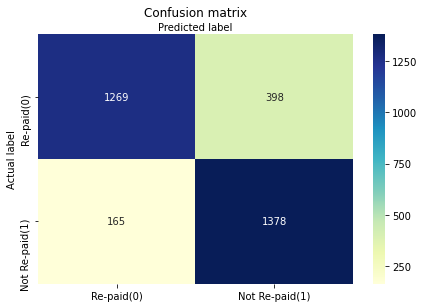

In [133]:
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
class_names=['Re-paid(0)','Not Re-paid(1)'] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)

# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g', xticklabels=class_names,
    yticklabels=class_names)
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.savefig("Confusion_matrix.jpg", dpi=100)

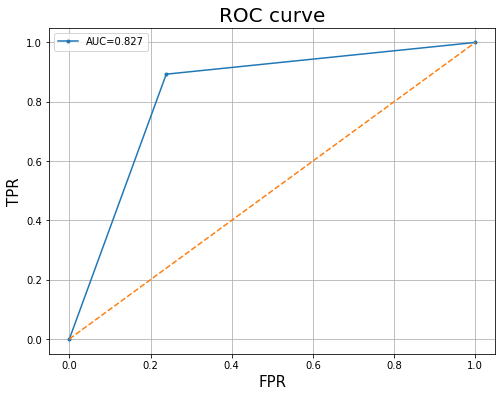

In [134]:
%matplotlib inline
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
auc = metrics.roc_auc_score(y_test, y_pred)
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, marker='.')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.title('ROC curve', fontsize = 20)
plt.xlabel('FPR', fontsize=15)
plt.ylabel('TPR', fontsize=15)
plt.grid()
plt.legend(["AUC=%.3f"%auc])
#plt.show()
plt.savefig("Roc_curve.jpg", dpi=100)

# 3. Feature Importances

In [ ]:
import eli5
from eli5.sklearn import PermutationImportance
model = KerasClassifier(build_fn = optimized_model, epochs = 150, batch_size = 64, verbose = 1).fit(X,y)

In [162]:

perm = PermutationImportance(model, random_state=1)


pipeline = Pipeline([('transform', transform_pipeline),
                                ('perm', perm)])
pipeline.fit(X, y)

12840/12840 [==============================] - 0s 6us/step


Pipeline(memory=None,
     steps=[('transform', ColumnTransformer(n_jobs=None, remainder='drop', sparse_threshold=0.3,
         transformer_weights=None,
         transformers=[('standardize_and_impute_pipeline', Pipeline(memory=None,
     steps=[('standardization', StandardScaler(copy=True, with_mean=True, with_std=True)), (...assifier object at 0x7f331ae07a20>,
           n_iter=5, random_state=1, refit=True, scoring=None))])

In [178]:
eli5.show_weights(pipeline.named_steps['perm'])

Weight,Feature
0.2783 ± 0.0087,x18
0.2166 ± 0.0095,x0
0.1951 ± 0.0053,x1
0.1781 ± 0.0022,x4
0.1725 ± 0.0046,x7
0.1645 ± 0.0042,x3
0.1629 ± 0.0047,x17
0.1600 ± 0.0035,x6
0.1576 ± 0.0050,x11
0.1563 ± 0.0042,x12
